In [1]:
import sys
import os
base_path = "/home/ubuntu/Projects/RL_sim/"
sys.path.insert(0, base_path)
os.chdir(base_path)

from agents.soft_q_learner import SoftQAgent
from agents.utils import *
from PIL.ImageOps import invert
from posixpath import join
from PIL import Image
from IPython import display

import matplotlib.pyplot as plt
import gymnasium as gym
import checkerboard_env
import pandas as pd
import numpy as np
import time

In [2]:
table = np.random.normal(0, 1, (10, 10))
kernel = generate_gaussian_kernel(5, 2)

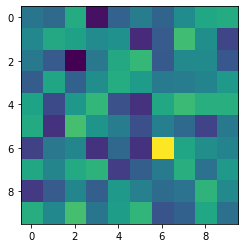

In [3]:
plt.imshow(table)

0.36787944117144233 1.0


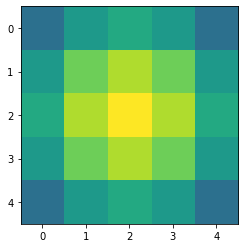

In [4]:
plt.imshow(kernel, vmin=0)
print(np.min(kernel), np.max(kernel))

In [5]:
from itertools import product

# Add parameter search;
parameters = {
    'snr': [2.0],
    'n_bins': [10],
    'q_mean': [0],
    'q_sigma': [0.1],
    'kernel_size': [10],
    'kernel_sigma': [2.0],
    'learning_rate': [0.1],
    'temperature': [0.5],
    'min_temperature': [1e-5],
    'max_temperature': [1.0],
    'reduce_temperature': [False],
    'decay_rate': [0.001]
}

# Generate all possible combinations
combinations = list(product(*parameters.values()))

# Convert the combinations into a list of dictionaries
parameter_combinations = [dict(zip(parameters.keys(), values)) for values in combinations]

# use one combination:
params = parameter_combinations[0]

In [6]:
def load_checkerboard(img, cross):
    
    board = Image.open(img)
    cross = Image.open(cross)

    if board.mode == 'RGBA':
        r,g,b,a = board.split()
        rgb_image = Image.merge('RGB', (r,g,b))
        rgb_inverse = invert(rgb_image)

        r2,g2,b2 = rgb_inverse.split()
        inverse = Image.merge('RGBA', (r2,g2,b2,a))

    else:
        inverse = invert(board)
    
    return board, inverse, cross

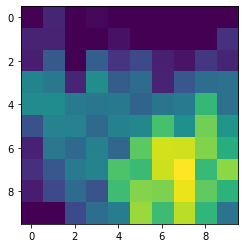

In [7]:
assets_path = "checkerboard_env/assets/"
board, inverse, cross = load_checkerboard(
    join(base_path, assets_path + "checkerboard.png"),
    join(base_path, assets_path + "cross.png")
)

env = gym.make('checkerboard-v0',
        render_mode=None,
        checkerboard=board,
        inverse=inverse,
        cross=cross,
        snr=params["snr"])

NUM_BINS = params["n_bins"]
BINS = create_bins(NUM_BINS)

q_table_shape = (NUM_BINS, NUM_BINS)  # contrast * frequency;
q_table = np.random.normal(params["q_mean"], params["q_sigma"], q_table_shape)
kernel = generate_gaussian_kernel(params["kernel_size"], params["kernel_sigma"])

model = SoftQAgent(
    env,
    q_table,
    kernel,
    learning_rate=params["learning_rate"],
    temperature=params["temperature"],
    min_temperature=params["min_temperature"],
    max_temperature=params["max_temperature"],
    reduce_temperature=params["reduce_temperature"],
    decay_rate=params["decay_rate"],
    num_bins_per_obs=NUM_BINS
)

initial_state = model.env.reset()[0]
discrete_state = discretize_observation(initial_state, BINS)

# Create a figure for the Q-table visualization
fig, ax = plt.subplots()

# fit the model;
for current_epoch in range(100):
    action = model.soft_q_action_selection()

    (next_state,
    reward,
    terminated,
    truncated,
    info) = model.env.step(action)

    # grab current q-value;
    old_q_value = model.q_table[discrete_state]

    # discretize the next state;
    next_state_discrete = discretize_observation(next_state, BINS)

    # compute next q-value and update q-table;
    model.q_table = model.update_q_table(reward, next_state_discrete, old_q_value)

    # update state;
    discrete_state = next_state_discrete

    # by default keep temperature constant;
    model.reduce_temperature(current_epoch, reduce=model.reduce_temp)
    model.reward_log.append(reward)

    # Display the Q-table
    ax.imshow(model.q_table, cmap='viridis', vmin=0, vmax=1.0)
    display.display(fig)
    display.clear_output(wait=True)

    # Optional: You can add a small delay to make the visualization smoother
    time.sleep(0.1)


### Calculate reward as % signal change

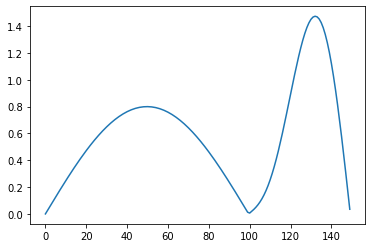

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
total_datapoints = 200
baseline_datapoints = 100
signal_datapoints = 50

# Generate time vector
time = np.linspace(0, 1, total_datapoints)

# Generate baseline part
baseline_amplitude = 0.8
baseline = baseline_amplitude * np.sin(2 * np.pi * 1 * time[:baseline_datapoints])

# Generate signal part with undershoots
signal_amplitude = 1.2
undershoot_amplitude = 0.5
signal = (
    signal_amplitude * np.sin(2 * np.pi * 2 * time[baseline_datapoints : baseline_datapoints + signal_datapoints])
    - undershoot_amplitude * np.sin(2 * np.pi * 4 * time[baseline_datapoints : baseline_datapoints + signal_datapoints])
)

# Combine baseline and signal
time_series = np.concatenate((baseline, signal))

# calculate % signal change;
baseline = np.mean(time_series[:100])
signal = np.mean(time_series[100:])

plt.plot(time_series)

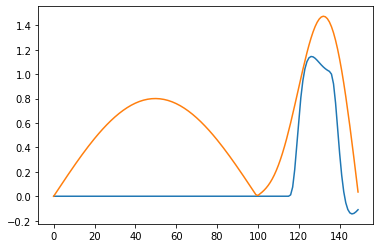

In [141]:
from nilearn.glm.first_level import compute_regressor

def generate_hrf_regressor(time_length, duration, onset, amplitude, tr=1.0):

    frame_times = np.linspace(0, time_length * tr, time_length)
    exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

    # Compute convolved HRF function;
    signal, _ = compute_regressor(
        exp_condition,
        "spm",
        frame_times,
        con_id="block"
    )
    return signal

hrf = generate_hrf_regressor(150, 20, 115, 1, tr=1.0)
plt.figure()
plt.plot(hrf)
plt.plot(time_series)
plt.show()

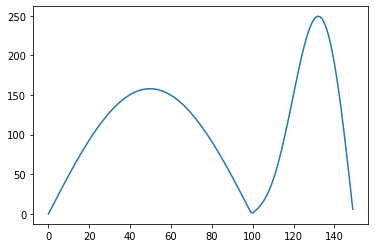

In [142]:
base = (time_series[:100] / np.mean(time_series[:100])) * 100
sig = (time_series[100:] / np.mean(time_series)) * 100

base_sig = np.hstack([base, sig])
plt.plot(base_sig)

In [143]:
import statsmodels.api as sm

def run_glm(y, x):
    x = sm.add_constant(x)
    return sm.OLS(y, x).fit().params[-1]

run_glm(base_sig, hrf) / 100

1.2885046753309786